# IMA204 Practical Session - Segmentation of medical images



This Practical work was written by Céline Liu and Eliot Guez.

# Introduction

Images to use are provided in a zip file called **data.zip** to install in your local directory from where you are running this notebook.

The goal of this practical session is to push K-means segmentation method as a pre-segmentation tool on different types of medical images: CT scans for the segmentation of kidneys and tumors, MRI for the corpus callosum in the brain , temporal sequences of MRI images for segmentation of the myocardium.

You are provided with pre-processing ideas. 
You will have to adjust a pipeline for **AT LEAST** one application (kidney/tumor, corpus callosum or heart).

You have to submit your code and comment your results. 

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) before the deadline (please check on Ecampus/Moodle). 

**The uploaded file should be named 'TP_SegMedImage_YOURSURNAME.ipynb'.** 

**RUN THE WHOLE NOTEBOOK FIRST TO GET A FULL OVERVIEW OF USE-CASES AND THE NOTION OF HYPERPARAMETERS.**

In [68]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# For ploting utilities of contours on images
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For listing files in local foler
import glob

# For loading .mat files
from scipy.io import loadmat

import skimage
from skimage.io import imread
from skimage import morphology
from skimage.segmentation import watershed 
from skimage.filters import rank
from skimage.util import img_as_ubyte
from skimage.morphology import disk
from scipy import ndimage
from skimage.measure import find_contours
import skimage.morphology as morpho  
from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage.filters import gaussian


# For Kmeans
import cv2 


Working_directory = os.getcwd()
print('Working_directory = ',Working_directory)


Working_directory =  g:\Mon Drive\2A\IMA\IMA204\TP medical image segmentation


In [69]:
def my_kmeans(image,k):
    #k = number of clusters
    
    # Reshaping the image  
    pixel_vals = image.reshape((-1,1)) 

    # Convert to float type only for supporting cv2.kmean
    pixel_vals = np.float32(pixel_vals)
    criteria   = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85) #criteria
    retval, labels, centers = cv2.kmeans(pixel_vals, k, 
                None, criteria, 10, cv2.KMEANS_PP_CENTERS) 
    centers = np.uint8(centers) # convert data into 8-bit values 
    
    segmented_data   = centers[labels.flatten()] # Mapping labels to center points( RGB Value)
    segmented_image  = segmented_data.reshape((image.shape)) # reshape data into the original image dimensions

    segmented_labels = labels # Mapping labels to center points( RGB Value)
    segmented_labels = segmented_labels.reshape((image.shape)) # reshape data into the original image dimensions
    
    return segmented_image,segmented_labels


def my_colormap_white_bkg(Colormap_name,numLabels):
    #numLabels = number of colors
    
    Colormap  = plt.get_cmap(Colormap_name, numLabels)
    newcolors = Colormap(np.linspace(0, 1, numLabels))
    bkg_color = np.array([256/256, 256/256, 256/256, 1])
    max_color = np.array([0/256, 0/256, 0/256, 1])
    newcolors[numLabels-1, :] = max_color
    newcolors[0, :] = bkg_color
    newcmp = ListedColormap(newcolors)
    return newcmp

## Abdominal CT 

You have at your disposal **6 abdominal CT scans** of different subjects. Subjects may have renal tumor. You also have the manual segmentations for both kidney and, when present, the tumor. 

Variables defined: <br>
* abdominalCT_path
* listImagesabdCT
* Img_abdo_ex
* Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

There are 6 abdomical CT images
Reading image  g:\Mon Drive\2A\IMA\IMA204\TP medical image segmentation/data/abdominalCT\CTs4.tiff
[  0 127]
There is no tumor


Text(0.5, 1.0, 'Image +contour tumor')

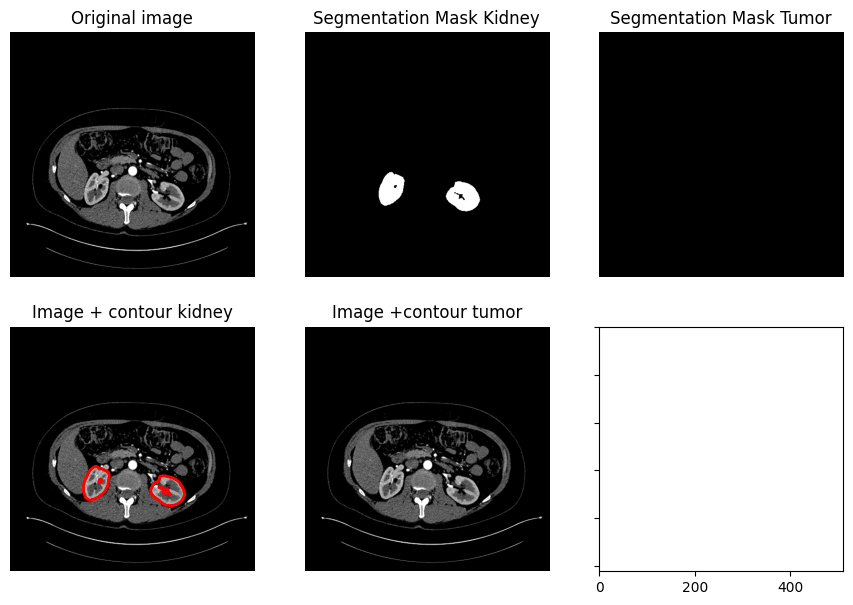

In [70]:
abdominalCT_path = Working_directory + '/data/abdominalCT'  
os.listdir(abdominalCT_path)
listImagesabdCT=glob.glob(abdominalCT_path + '/*-seg.tiff')
print('There are', len(listImagesabdCT),  'abdomical CT images')

# Choose a figure and plot it with the ground truth segmentation
indexIm=5 # between 0 and 5

# Abdominal CT
filename_Segmentation = listImagesabdCT[indexIm]
Labels_abdo_ex   = imread(filename_Segmentation)
filename         = filename_Segmentation[:-9] + '.tiff'
Img_abdo_ex      = imread(filename) 

print('Reading image ', filename)
print(np.unique(Labels_abdo_ex))

if Img_abdo_ex.shape != Labels_abdo_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Labels_abdo_ex we may have two values: 127 is for kidney and 255 for renal tumor
Seg_abdo_kidney_ex=Labels_abdo_ex==127
if np.sum(Seg_abdo_kidney_ex)==0:
  print('There is no kidney')
Cont_abdo_kidney_ex = find_contours(Seg_abdo_kidney_ex, 0.5)

Seg_abdo_tumor_ex=Labels_abdo_ex==255
if np.sum(Seg_abdo_tumor_ex)==0:
  print('There is no tumor')
Cont_abdo_tumor_ex = find_contours(Seg_abdo_tumor_ex, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_abdo_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(Seg_abdo_kidney_ex,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask Kidney")
grid[2].imshow(Seg_abdo_tumor_ex,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Segmentation Mask Tumor")
grid[3].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_kidney_ex:
  grid[3].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[3].axis('off')
grid[3].set_title("Image + contour kidney")
grid[4].imshow(Img_abdo_ex, cmap='gray')
for contour in Cont_abdo_tumor_ex:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[4].axis('off')
grid[4].set_title("Image +contour tumor")

# Brain MRI

Here you can select medial slices of the brain of **4 different subjects**. You also have manual segmentations of the corpus callosum.

Variables defined: <br>
* brainMRI_path
* listImagesbrainMRI
* Seg_brain_ex
* Img_brain_ex

There are 4 brain MRI images
['g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs1-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs2-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs3-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs4-seg.png']
Reading image  g:\Mon Drive\2A\IMA\IMA204\TP medical image segmentation/data/brainMRI\MRIs3.png


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\imageio\plugins\pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


Text(0.5, 1.0, 'Image with segmentation\n corpus callosum')

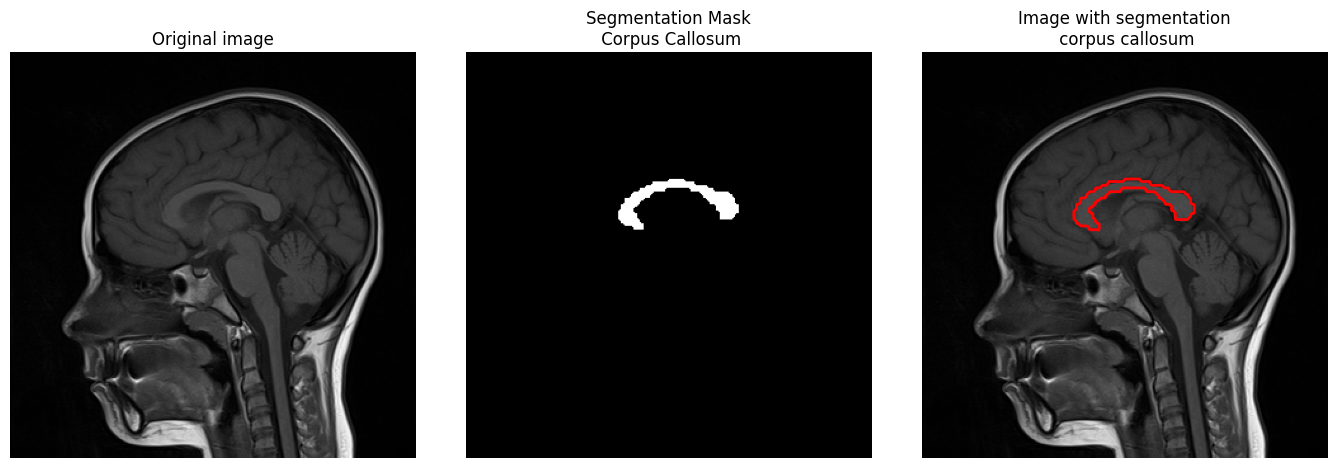

In [71]:
brainMRI_path = Working_directory + '/data/brainMRI'
os.listdir(brainMRI_path)
listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
print('There are', len(listImagesbrainMRI),  'brain MRI images')
print(listImagesbrainMRI)

# Choose a brain MRI and plot it with the ground truth segmentation
indexIm      = 2 # between 0 and 3
filename_seg = listImagesbrainMRI[indexIm]
Seg_brain_ex = imread(filename_seg)
filename     = filename_seg[:-8] + '.png'
Img_brain_ex = imread(filename) 

print('Reading image ', filename)

if Img_brain_ex.shape != Seg_brain_ex.shape:
  raise NameError('image and mask should have the same shape, problem...')  

# In Im Seg we have masks of the corpus callosum
maskCC      = Seg_brain_ex==255
contourMask = find_contours(maskCC, 0.5)

fig = plt.figure(figsize=(17, 7))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(Img_brain_ex, cmap='gray')
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(maskCC,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Segmentation Mask\n Corpus Callosum");
grid[2].imshow(Img_brain_ex, cmap='gray')
for contour in contourMask:
  grid[2].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
grid[2].axis('off')
grid[2].set_title("Image with segmentation\n corpus callosum")


# Cardiac MRI 

The last section is about MRI sequences of the heart. 
You are provided with **a single use case**. 
Your goal is to segment the left ventricule. Be careful, the segmentation is not a maks but a series of points (landmarks). To obtain a binary mask, you should first interpolate the points (using for instance a spline). <br> 

The structure of this image data is more complex and needs some coding to load single slices to segment.


Variables defined: <br>
* MRIheart_path
* Img_cardiac_ex
* Seg_cardiac_ex


MRI volume of the heart composed of 11 slices along the z axis and 20 temporal frames. Each slice is an image  256  x  256
For each slice and at each time frame we have a manual segmentation composed of 65 2D landmarks
Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value: [[-99999]]


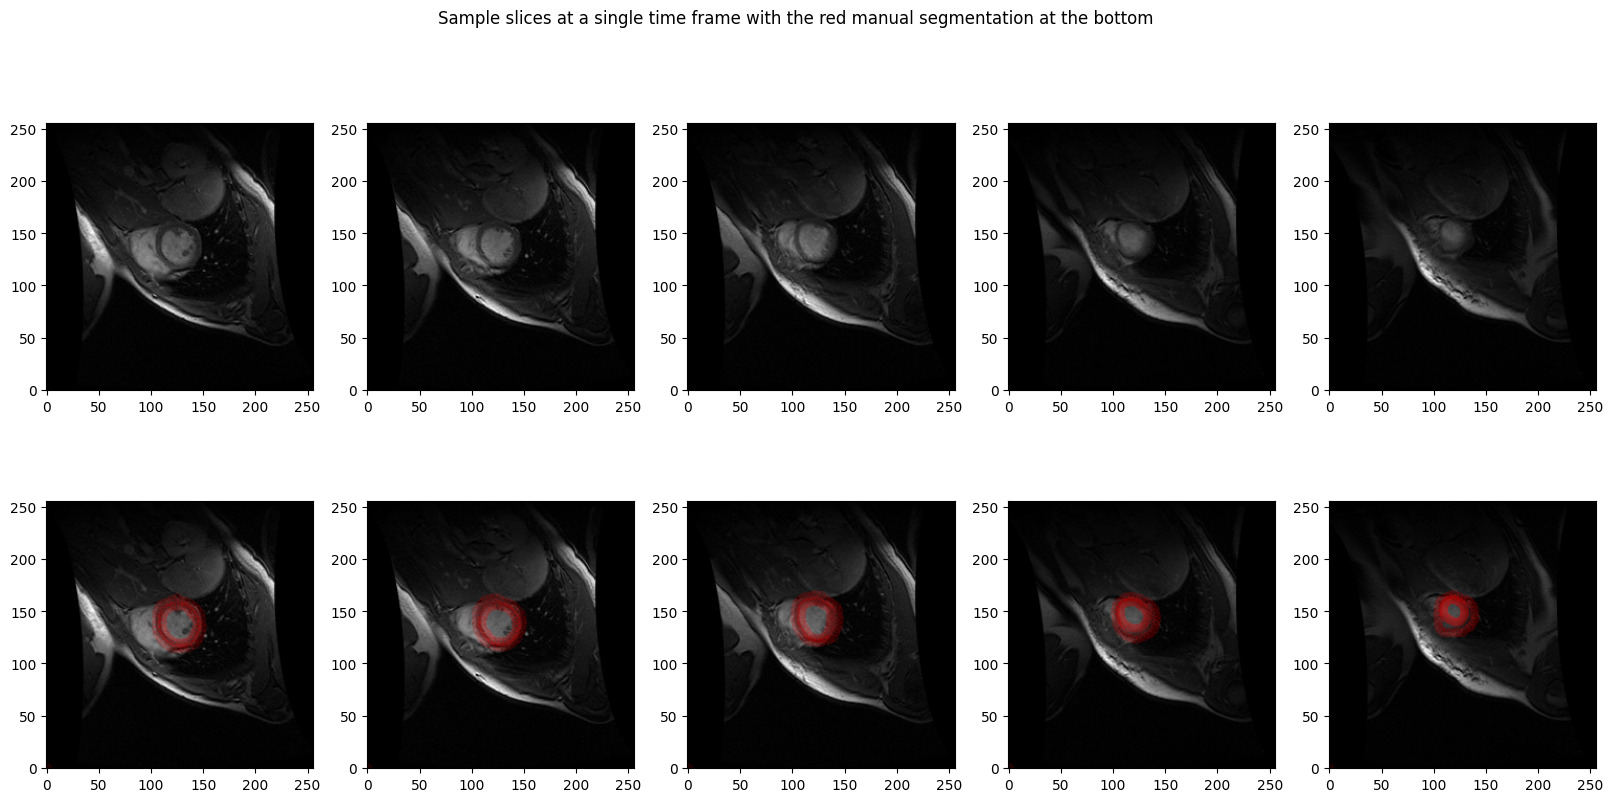

In [72]:
# Read one case
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

Ex_index_select = 4
Img_cardiac_ex = data[:,:,Ex_index_select,1] # can be index 4,5,6,...
Cont_cardiac_ex = seg[Ex_index_select,1][:]

print('MRI volume of the heart composed of', data.shape[2], 'slices along the z axis and', data.shape[3], 
'temporal frames. Each slice is an image ', data.shape[0], ' x ',  data.shape[1])
print('For each slice and at each time frame we have a manual segmentation composed of',seg[4,4].shape[0] , '2D landmarks')

print('Be careful, some slices do not contain the left ventricle myocardium and the manual segmentation is not simply empty but it contains the value:', seg[0,0] )

plt.figure(figsize=(20, 9))
plt.suptitle('Sample slices at a single time frame with the red manual segmentation at the bottom')
plt.subplot(2, 5, 1)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 2)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 3)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 4)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 5)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 

plt.subplot(2, 5, 6)
plt.imshow(data[:,:,4,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[4,1][:,0], seg[4,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 7)
plt.imshow(data[:,:,5,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[5,1][:,0], seg[5,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 8)
plt.imshow(data[:,:,6,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[6,1][:,0], seg[6,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 9)
plt.imshow(data[:,:,7,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[7,1][:,0], seg[7,1][:,1], c='r',alpha=0.1) 

plt.subplot(2, 5, 10)
plt.imshow(data[:,:,8,1],cmap="gray")
plt.gca().invert_yaxis() 
plt.scatter(seg[8,1][:,0], seg[8,1][:,1], c='r',alpha=0.1); 

## For cardiac MRI: how to create a binary mask from the provided contours

Number of points in the contour: 64


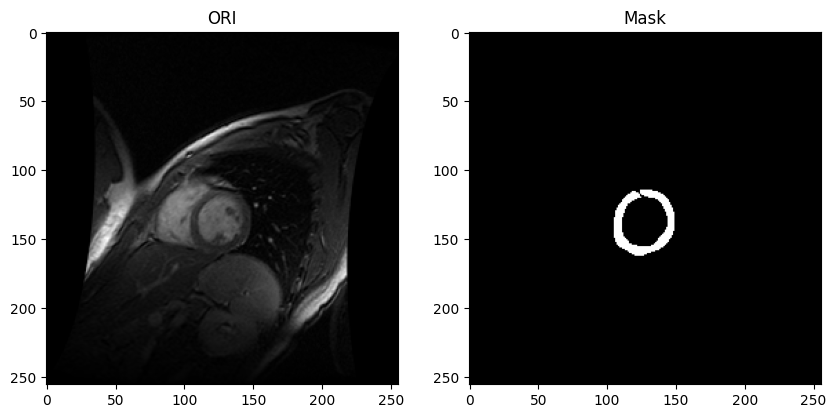

In [73]:
from skimage.draw import polygon

# Remove [0 0] point in provided contour
Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]
print('Number of points in the contour:', Cont_cardiac_ex.shape[0])

Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex, dtype='bool')
rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
Seg_cardiac_ex[rr, cc] = 1

fig, axes        = plt.subplots(1,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_cardiac_ex,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Seg_cardiac_ex,cmap='gray')
ax[1].set_title("Mask")

plt.show()

# Preliminaries
## Mathematical Morphology

Incitations to use morphological operators seen during the previous lectures to segment the provided images. 


Think about the structural elements and the hyper-parameters ... We typically adapt their values to the image resolution and type of structures targeted in our segmentation (eg. brigth or dark).



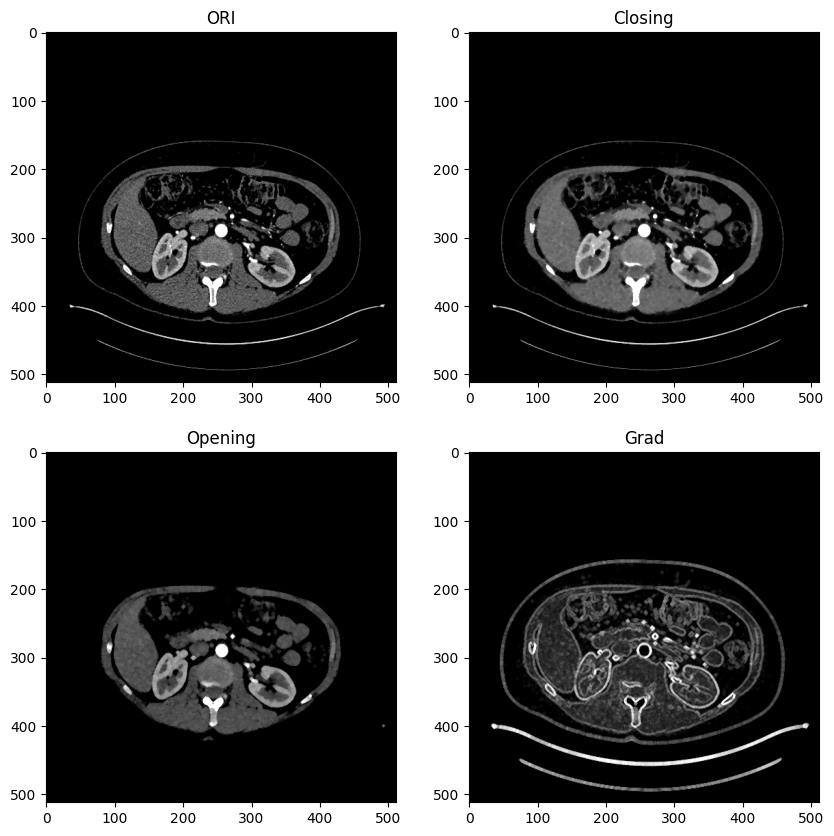

In [74]:
#Select input image
# Img_test         = Img_cardiac_ex
# Img_test         = Img_brain_ex
Img_test         = Img_abdo_ex ; # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex

# Define Element
Radius           = 2
se               = disk(Radius)

# Morpho closing
Img_test_close  = morpho.closing(Img_test,se)

# Morpho Opening
Img_test_open    = morpho.opening(Img_test,se)

# Morpho Gradient
Img_test_grad  = morpho.dilation(Img_test,se)-morpho.erosion(Img_test,se)


#Figure display
fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(Img_test_close,cmap='gray')
ax[1].set_title("Closing")
ax[2].imshow(Img_test_open,cmap='gray')
ax[2].set_title("Opening")
ax[3].imshow(Img_test_grad,cmap='gray')
ax[3].set_title("Grad")

plt.show()

# Preliminaries
## Regular filtering

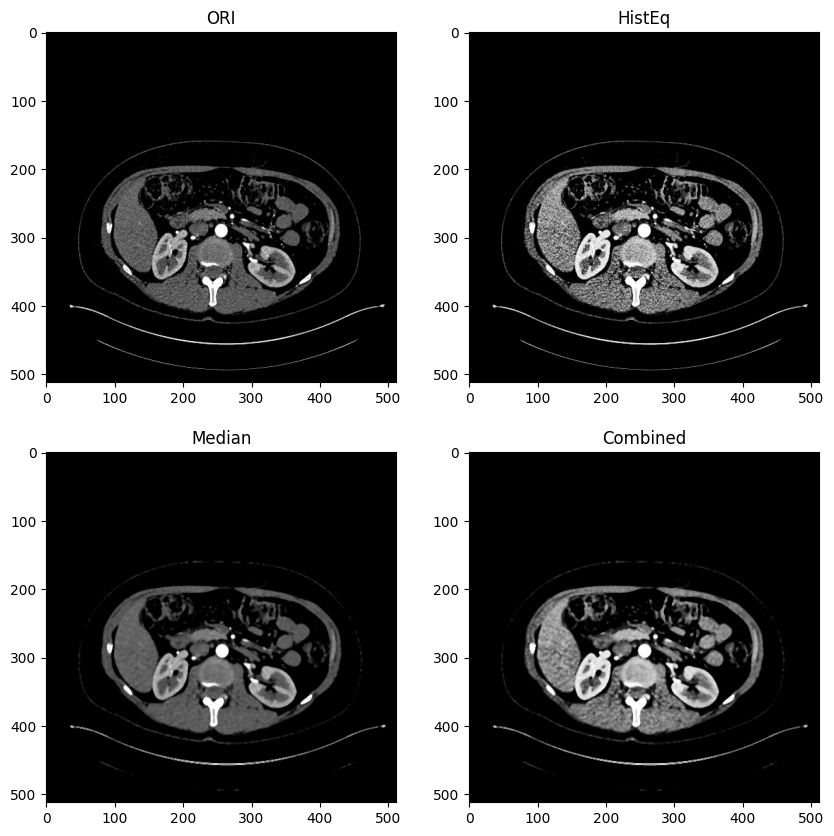

In [75]:

img_histeq    = skimage.exposure.equalize_adapthist(Img_test, clip_limit=0.03)
img_median    = ndimage.median_filter(Img_test, size=4)
img_histeqmed = ndimage.median_filter(img_histeq, size=4)

fig, axes        = plt.subplots(2,2, figsize=(10, 10))
ax               = axes.ravel()
ax[0].imshow(Img_test,cmap='gray')
ax[0].set_title("ORI")
ax[1].imshow(img_histeq,cmap='gray')
ax[1].set_title("HistEq")
ax[2].imshow(img_median,cmap='gray')
ax[2].set_title("Median")
ax[3].imshow(img_histeqmed,cmap='gray')
ax[3].set_title("Combined");




# ASSIGNMENT:

**Question** 
Develop a segmentation pipeline building upon **kmeans** as proposed below for **at least one application** and report quality of segmentation results comparing your results to the provided ground truth on multiple images.

We want you to focus on **pre-processing** your image AND **post process** your segmentation result to extract **THE structure of interest**. For the postprocessing you can rely on extraction of connected components and apply to criteria (size, shape, position,..) to extract the composant that most likely corresponds to the structure of interest. 


When processing medical images, and given that you are provided with several ground-truth (gt) segmentations you can push the exercice to consider: <br>
* Cropping the field of view to remove the background (a common issue in medical images)
* Target a range of intensity values based on learning from the gt masks and corresponding images 
* Learn priors on shape/intensity statistics from the provided gt masks


## Kmeans routine to segment your images
Kmeans is very often used as pre-segmentation to initialise a finer segmentation.

Provides a segmentation of the image using k-means clustering.
Be careful: Kmeans uses random initialisation and is therefore different at each run and randomly assigns  labels to clusters (0,1,2,...,K).

 



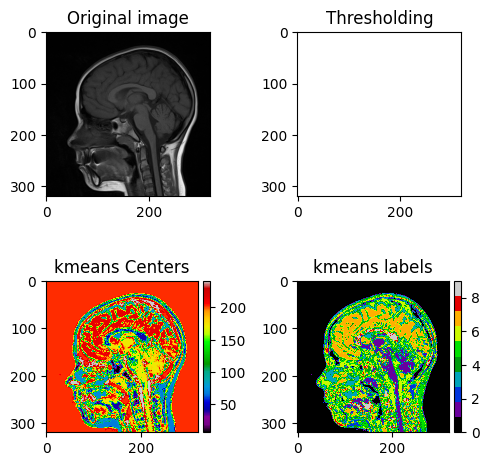

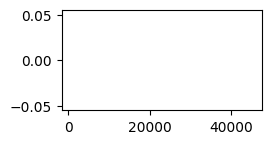

Your Target_value =  8716
Distance of your Target_value to Centers =  [ 8002  7584 36666  1084 17915 47417  2843  4299 26754 11292]
Your selected label (starting with 0)=  3


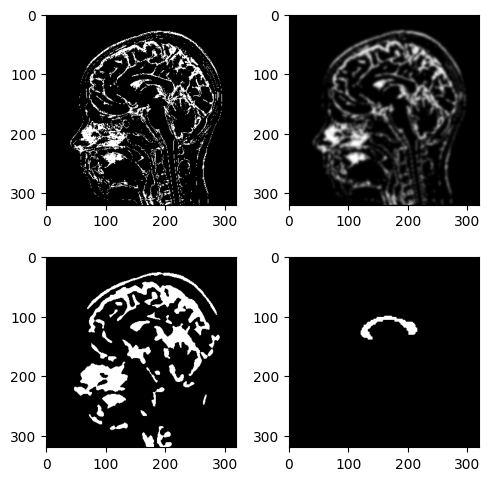

In [76]:
# Image use-case and HYPER-PARAMETER values provided as a good start

# Img_test         = Img_abdo_ex ; Img_seg_gt       = Seg_abdo_kidney_ex # With: Seg_abdo_kidney_ex, Seg_abdo_tumor_ex
# nber_clusters    = 10; Target_value_thresh = 180 # For cardiac image
# Img_test            = Img_cardiac_ex; Img_seg_gt       = Seg_cardiac_ex
# nber_clusters       = 10; Target_value_thresh = 150 # For abdo image
Img_test          = Img_brain_ex ; Img_seg_gt       = Seg_brain_ex
nber_clusters     = 10; Target_value_thresh = 50 # For brain image




# [1] Example of segmentation via simple threshold 
# Compute a mask thresholding above target value
Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          Img_test > Target_value_thresh, 
                            min_size=500,connectivity=1),
                             area_threshold=500)
Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(3))
Seg_thresh = Seg_thresh.astype('uint8')


# [2] Example of segmentation via kmeans 
Seg_km,Seg_km_labels = my_kmeans(Img_test,nber_clusters)
# get discrete colormap to display results
Colormap  = plt.get_cmap('nipy_spectral', nber_clusters)

# Display results
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

ax[0].imshow(Img_test, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(Seg_thresh, cmap='gray')
ax[1].set_title('Thresholding')

tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
divider   = make_axes_locatable(ax[2])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[2].set_title('kmeans Centers')
fig.colorbar(tmp, cax=cax, orientation='vertical')

tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
divider = make_axes_locatable(ax[3])
cax     = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(tmp, cax=cax, orientation='vertical')
ax[3].set_title('kmeans labels')

fig.tight_layout()
plt.show();

# Get mean pixel intensity values under all Kmeans labels
Img_label_means = np.empty(nber_clusters)
for i in range(0,nber_clusters):
    Img_label_mask = Seg_km_labels==i
    Img_label_mask = Img_label_mask.astype('uint8')
    tmp            = cv2.mean(Img_test, Img_label_mask)
    Img_label_means[i] = tmp[0]
#print(Img_label_means)

# Plot histograms of Kmeans clusters
Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                         bins=Bins)
bar_width = 5
fig       = plt.figure(figsize=(2, 1))
ax        = fig.add_axes([0,0,1,1])
ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
plt.show()

# Set a target intensity value and get the Kmeans label closest to it
Target_value = cv2.mean(Img_test, Seg_thresh)
Target_value = Target_value[0]
Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
Label_select = np.argmin(Diff)
print('Your Target_value = ', np.round(Target_value).astype(int))
print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
print('Your selected label (starting with 0)= ', Label_select)



# Filter the selected label and get a binary segmentation mask
Img_label_select  = Seg_km_labels==Label_select
Img_label_select  = Img_label_select.astype('float64')


# Examples to refine your segmentation mask
Img_label_select_smooth = gaussian(Img_label_select, 2, 
                            preserve_range=True)

Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth>0.25, min_size=50,connectivity=1),
    area_threshold=50)


fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()
ax[0].imshow(Img_label_select, cmap='gray')
ax[1].imshow(Img_label_select_smooth, cmap='gray')
ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')
ax[3].imshow(Img_seg_gt, cmap='gray')

fig.tight_layout()
plt.show()

In [77]:
from skimage.segmentation import active_contour # For active_contour function

## From Kmeans to Connected Components

This is an example on how to exploit the results from Kmeans.
Note that this example uses several hard-coded **hyperparameters** which is not appropriate to segment robustly several cases. 

If you reuse this piece of code for the question below, propose some approaches to set some of the hyperparameter values automatically (eg using the known average size of the structure of interest from the gt segmentation you have)
 



Max value in labels =  15
Number of connected components =  16


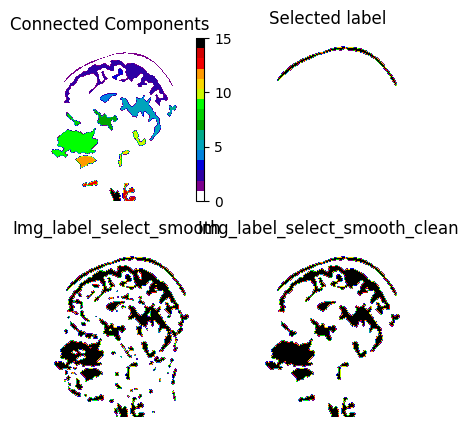

In [78]:
Img_label_select_filter = gaussian(Img_label_select, 2, 
                            preserve_range=True)
Img_label_select_smooth = Img_label_select_filter>0.25
Img_label_select_smooth_clean = morphology.remove_small_holes(
    morphology.remove_small_objects(
        Img_label_select_smooth, min_size=150,connectivity=1),
    area_threshold=150)

# Extract connected components
Thresh = Img_label_select_smooth_clean
output = cv2.connectedComponentsWithStats(Thresh.astype(np.uint8))
(numLabels, labels, stats, centroids) = output
print('Max value in labels = ',labels.max())
print('Number of connected components = ',numLabels)

# Extract 1 connected component
thresh = labels==1

# plots results
Colormap = my_colormap_white_bkg('nipy_spectral',numLabels)
fig, axes = plt.subplots(2,2, figsize=(5, 5))
ax        = axes.ravel()

tmp     = ax[0].imshow(labels, cmap=Colormap)
divider   = make_axes_locatable(ax[0])
cax       = divider.append_axes('right', size='5%', pad=0.05)
ax[0].set_title('Connected Components')
ax[0].axis('off')
fig.colorbar(tmp, cax=cax, orientation='vertical')

ax[1].imshow(thresh, cmap=Colormap)
ax[1].set_title('Selected label')
ax[1].axis('off')
ax[2].imshow(Img_label_select_smooth, cmap=Colormap)
ax[2].set_title('Img_label_select_smooth')
ax[2].axis('off')
ax[3].imshow(Img_label_select_smooth_clean, cmap=Colormap)
ax[3].set_title('Img_label_select_smooth_clean');
ax[3].axis('off');




## Implement your full segmentation pipeline

### TO DO:
* Implement a full pipeline to segment TWO EXAMPLES from a single use case. Your code must run over the two cases in a loop. We need to be able to run the code without any adjustment to local path to access the input data. <br>
* Implement and compute a quality metric (eg Dice, overlap, relative area differences, errors between max diameters (something used to measure tumors), distances between contours) that compares your final segmentation with the ground-truth.
* Extra point if you provide results on more use-cases or more than 2 examples per use case. <br>
* Feel free to also test your segmentation pipeline on images degraded by noise for example. <br>
* Your final solution can involve registration or active contours from previous lectures. Just make sure to include the required functions and imports in your final notebook.<br>

### If you use the cardiac MRI dataset:
* Extra point because extra difficulties to load and prepare the data. <br>
* In this case the data preparation is part of your code below as you can only rely on the input data provided as it is.  <br>
* Use any slice from any case you want as your "learning" ground truths on which you can learn object size or shape characteristics for example. <br>
* Test your segmentation on any slice from any case, as long as the slices were not part of your "learning" ground-truth. <br>
* See if you can get your solution to not detect anything on slices that don't contain the left ventricle myocardium. <br>


### Important instructions:
* You cannot use the ground truth of the images you segment to segment them! But you can use the ground-truths of other examples of the same use-case to learn a priori knowledge such as size or average pixel intensity.<br>
* List all your hard-coded hyperparameters at the beginning of your code, indicating a variable name and its value. You will be penalised if you leave any hard-coded hyperparameter values inside your code. <br>

Nb: Dice = np.sum([seg==gt])*2.0/(np.sum(seg)+np.sum(gt)) #seg is the segmentation and gt is the ground truth. Both are of same size

In [ ]:
def dice_coeff(inputs, target): 
    intersection = inputs * target
    dice = (2. * intersection.sum()) / (inputs.sum() + target.sum())
    return dice

In [120]:
# Hyper-parameters

# For cardiac image

# for cropping 
x1, x2, y1, y2 = 113, 170, 95, 150
# kmeans : groupe 1
nber_clusters_1     = 5; Target_value_thresh_1 = 0.5  ## après avoir testé plusieurs valeurs, j'ai choisi nber_clusters = 5 et Target_value_thresh = 0.50
nber_clusters_2     = 7; Target_value_thresh_2 = 0.54 


In [122]:
MRIheart_path = Working_directory + '/data/MRIheart/'
os.listdir(MRIheart_path)
data          = loadmat(MRIheart_path + 'dataMRIheart.mat')
data          = data['data']
seg           = loadmat(MRIheart_path + 'segMRIheart.mat')
seg           = seg['seg']

n = data.shape[2]
list_images = [data[:, :, i, 1] for i in range(n)]
cont = [seg[i, 1][:] for i in range(n)]


Sur les 2 premières et deux 2 dernières images on ne voit pas la ventricule gauche puisqu'on ne trouve pas le contour. Donc on va supprimer ces 4 images :

In [123]:
list_images.pop(n-1) ; list_images.pop(n-2) ; list_images.pop(1) ; list_images.pop(0)
cont.pop(n-1); cont.pop(n-2) ; cont.pop(1) ; cont.pop(0) 
n = len(list_images)

segmentations = np.empty(n, dtype=object)
for i, Cont_cardiac_ex in enumerate(cont):
  Cont_cardiac_ex = Cont_cardiac_ex[~np.all(Cont_cardiac_ex == 0, axis=1)]
  print('Number of points in the contour:', Cont_cardiac_ex.shape[0])
  Seg_cardiac_ex   = np.zeros_like(Img_cardiac_ex)
  rr, cc = polygon(Cont_cardiac_ex[:, 1], Cont_cardiac_ex[:, 0], Img_cardiac_ex.shape)
  Seg_cardiac_ex[rr, cc] = 1
  segmentations[i] = Seg_cardiac_ex

Number of points in the contour: 64
Number of points in the contour: 64
Number of points in the contour: 64
Number of points in the contour: 64
Number of points in the contour: 64
Number of points in the contour: 64
Number of points in the contour: 64


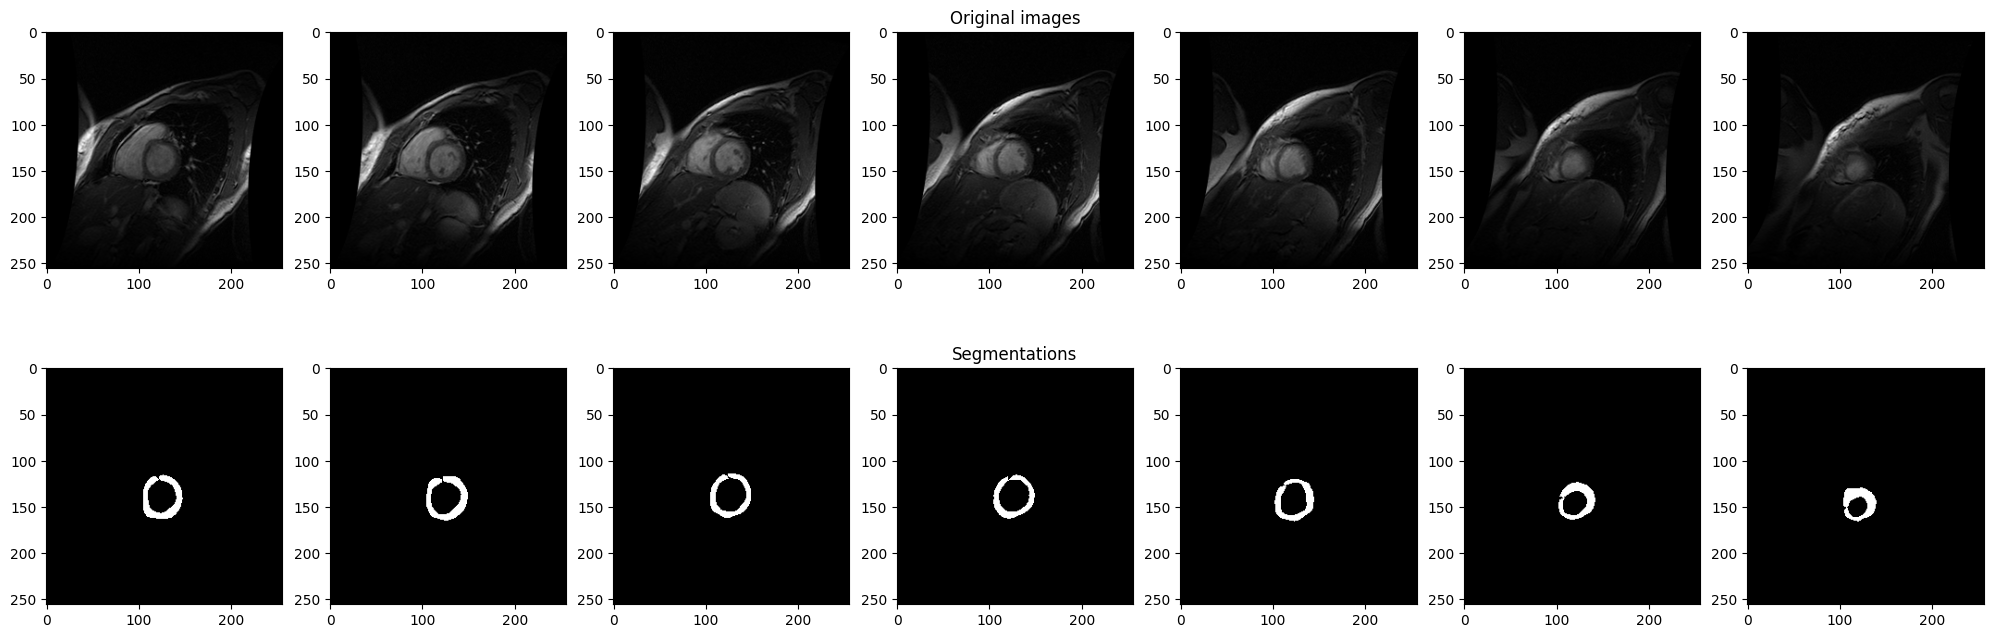

In [124]:
# Plot the images and the segmentations
fig, ax = plt.subplots(2, n, figsize=(25, 8))
ax[0, 3].set_title('Original images') 
ax[1, 3].set_title('Segmentations')

for i in range(n):
  ax[0, i].imshow(list_images[i], cmap='gray')
  ax[1, i].imshow(segmentations[i], cmap='gray')

On va cropper les images pour se concentrer sur la partie qui nous intéresse. 

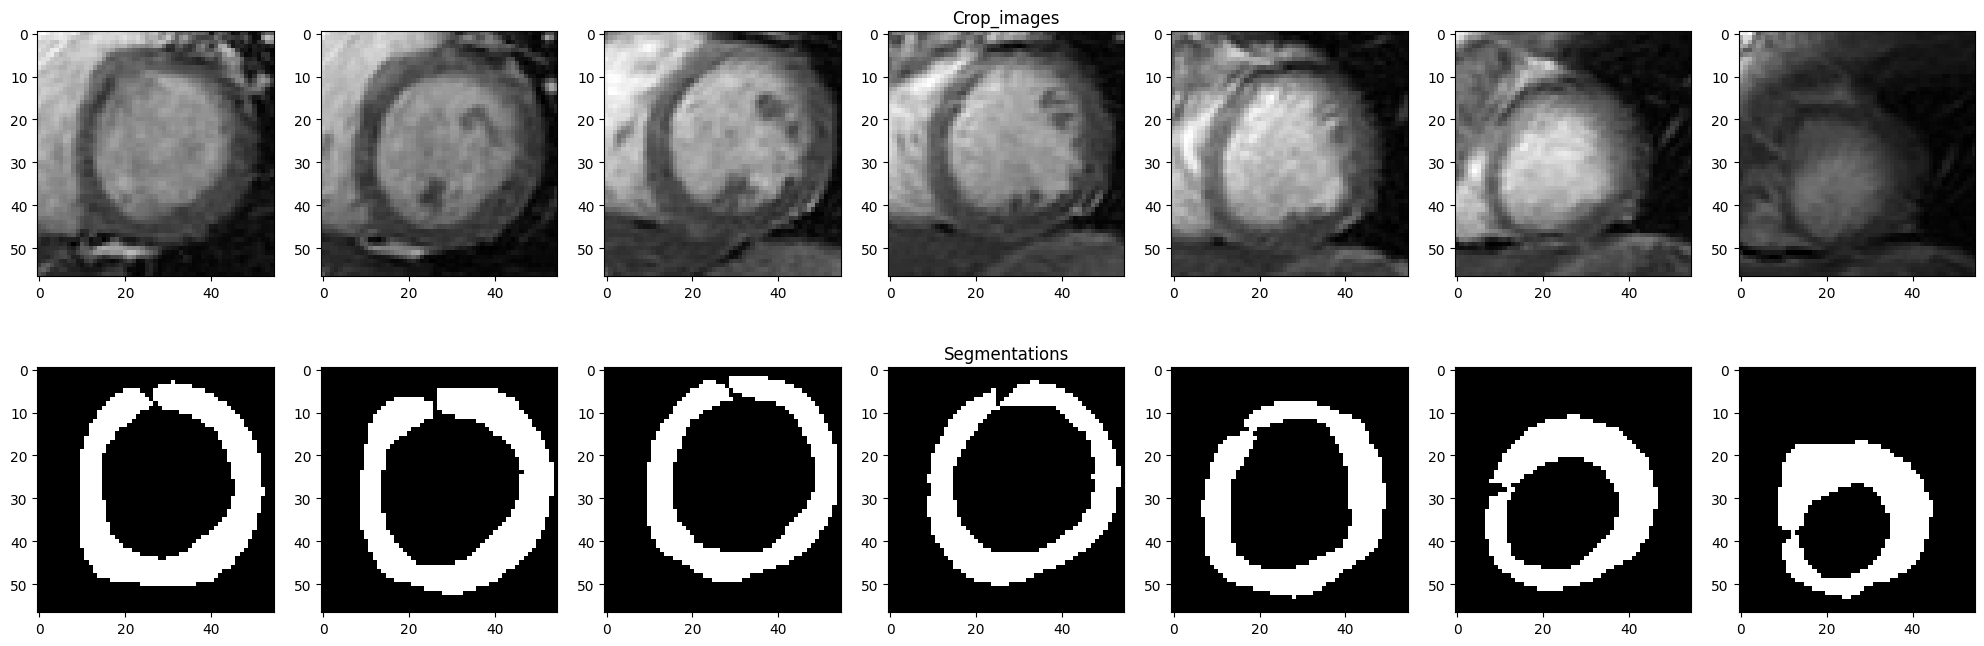

In [125]:
crop_images, crop_segmentations = [], []

for img in list_images:
  crop_images.append(img[x1: x2, y1: y2])
for seg in segmentations:
  crop_segmentations.append(seg[x1: x2, y1: y2])

fig, ax = plt.subplots(2, 7, figsize=(25, 8))
ax[0, 3].set_title('Crop_images')
ax[1, 3].set_title('Segmentations')

for i in range(7):
  ax[0, i].imshow(crop_images[i], cmap='gray')
  ax[1, i].imshow(crop_segmentations[i], cmap='gray')

On souhaite avoir la même luminosité sur toutes les images. On va plutôt normaliser les images entre 0 et 1 après avoir détruit seuillé au maximum les 5% des pixels de plus hautes intensités, on ne fait pas d'égalisation d'histogramme parce que le kmean ne fonctionne pas bien avec les images égalisées.
On applique un filtre médian ensuite pour enlever le bruit, et avoir un cercle un peu plus large quitte à avoir une image plus floue.

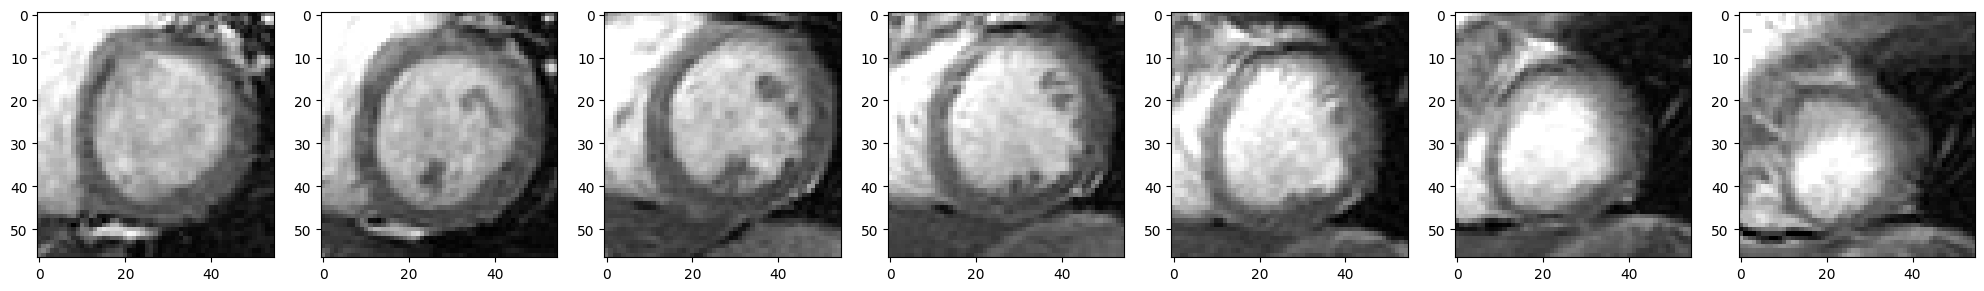

In [126]:
################# normalize image between 0 and 1
def normalize_image(img):
  return (img - img.min()) / (img.max() - img.min())
#################

normalized = []
for img in crop_images:
  # on cherche le seuil des  5% des pixels les plus clairs
  seuil = np.percentile(img, 95)
  img_norm = img / seuil
  img_norm[img_norm > 1] = 1
  norm_img = normalize_image(img_norm)
  normalized.append(norm_img)

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(normalized[i], cmap='gray')

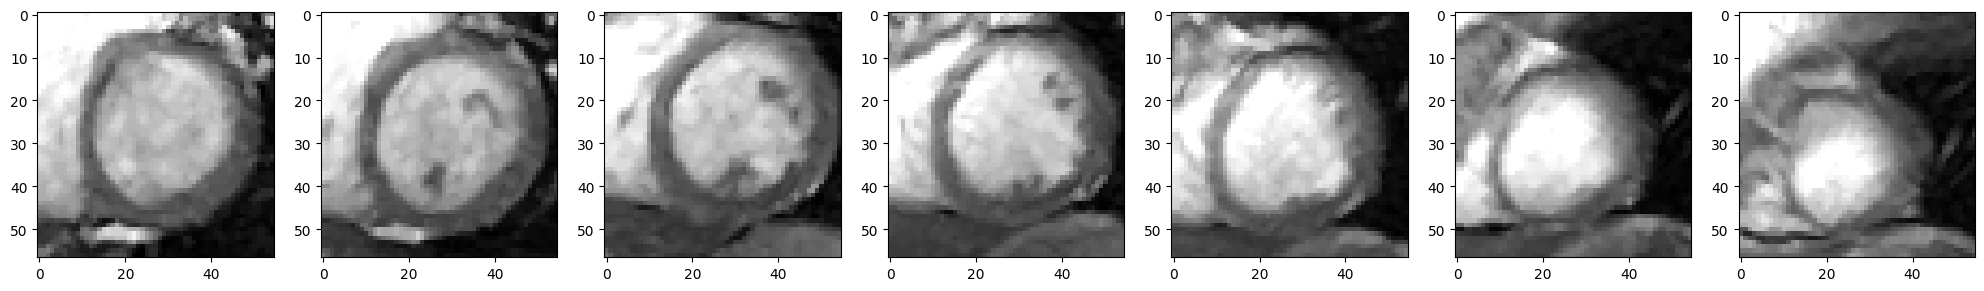

In [127]:
# on débruite les images avec un filtre médian 
denoised = []
for img in normalized:
  denoised.append(ndimage.median_filter(img, size=2))

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(denoised[i], cmap='gray')

On applique l'algorithme kmean. on va séparer le nombre de cluster et la valeur de target_value_thresh en fonction de si le coeur fait partie des premières images ou des dernières

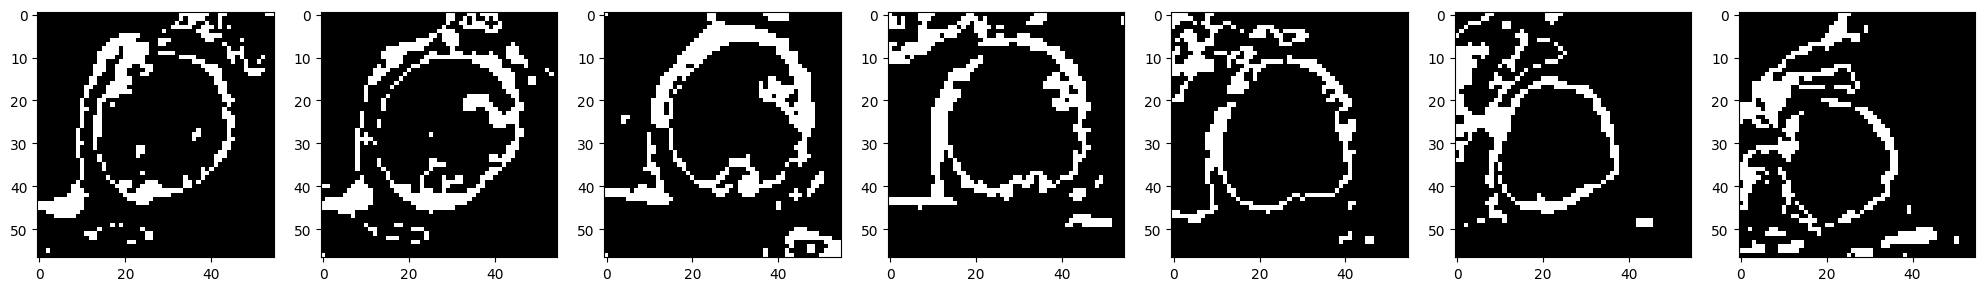

In [128]:
img_seg = []

for img in denoised[:4]:
  Seg_km, Seg_km_labels = my_kmeans(img, nber_clusters_1)
  Img_label_means = np.empty(nber_clusters_1)

  for i in range(0,nber_clusters_1):
      Img_label_mask = Seg_km_labels==i
      Img_label_means[i] = img[Img_label_mask].mean()
  label = np.argmin(np.absolute(Img_label_means-Target_value_thresh_1*np.ones(nber_clusters_1)))

  img_seg.append(Seg_km_labels==label)


for img in denoised[4:]:
  Seg_km, Seg_km_labels = my_kmeans(img, nber_clusters_2)
  Img_label_means = np.empty(nber_clusters_2)

  for i in range(0,nber_clusters_2):
      Img_label_mask = Seg_km_labels==i
      Img_label_means[i] = img[Img_label_mask].mean()
  label = np.argmin(np.absolute(Img_label_means-Target_value_thresh_2*np.ones(nber_clusters_2)))

  img_seg.append(Seg_km_labels==label)


fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(img_seg[i], cmap='gray')

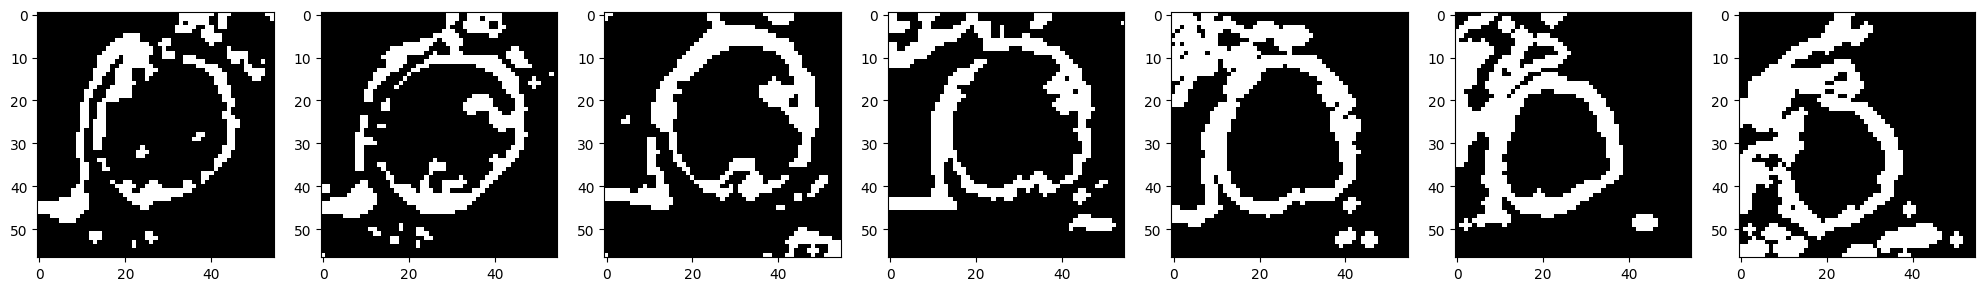

In [138]:
img_seg_morpho= []

for i in range(4):
    img_seg_m = img_seg[i]
    img_seg_m = ndimage.median_filter(img_seg_m, size=2)
    #img_seg_m = morphology.remove_small_holes(morphology.remove_small_objects(img_seg[i], min_size=20,connectivity=1),area_threshold=50)

    img_seg_morpho.append(img_seg_m)

for i in range(4,7):
    img_seg_m = img_seg[i]
    img_seg_m = ndimage.median_filter(img_seg_m, size=2)
    img_seg_m = morphology.dilation(img_seg[i],morphology.disk(1))
    #img_seg_m = morphology.remove_small_holes(morphology.remove_small_objects(img_seg[i], min_size=20,connectivity=1),area_threshold=50)

    img_seg_morpho.append(img_seg_m)

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(img_seg_morpho[i], cmap='gray')

On garde à nouveau la plus grande composante.

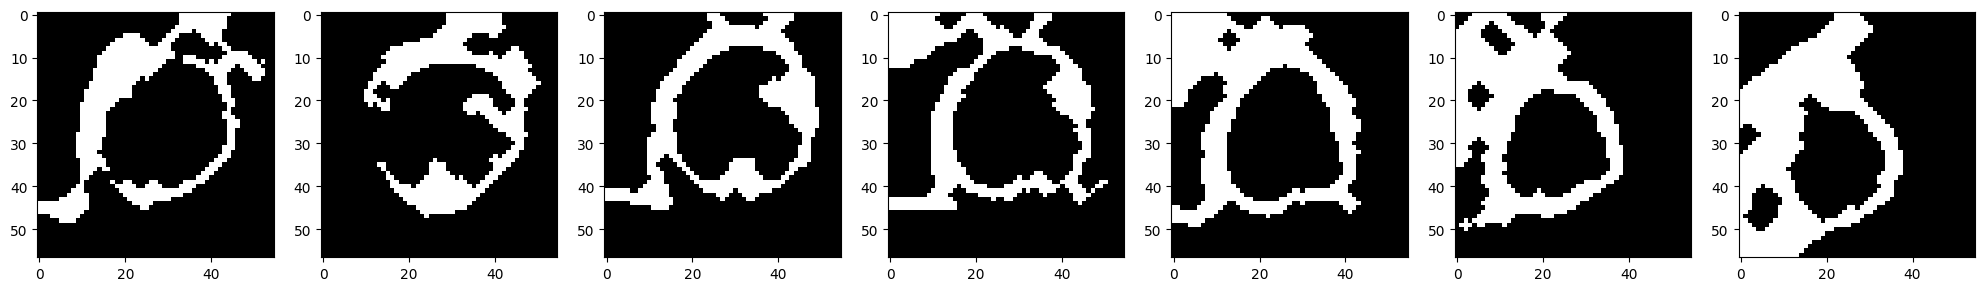

In [139]:
from skimage.measure import label   

segm = []

for seg in img_seg_morpho:
  tmp = morpho.binary_closing(seg, disk(2))
  labels = label(tmp)
  segm.append(labels == np.argmax(np.bincount(labels.flat)[1:])+1)

fig, ax = plt.subplots(1, 7, figsize=(25, 8))
for i in range(7):
  ax[i].imshow(segm[i], cmap='gray')

In [140]:
for i in range(n):
  print(dice_coeff(segm[i], crop_segmentations[i]))

0.40511440107671604
0.4045393858477971
0.4209039548022599
0.38324175824175827
0.3951219512195122
0.33396345305608066
0.3504171632896305


on a du mal à retrouver des résultats excellents malgré toutes les tentatives pour affiner le masque mais on peut considérer qu'en utilisant toutes l'image et pas seulement la partie rogné, le  dice tendera bien plus vers 1. 

Nous avons également tenté une autre méthode pour segmenter le corpus callosum des IRM de cerveaux.

In [141]:
from skimage import measure
from skimage import filters

In [142]:
## Hyper-Parameters for brain image
Target_value_thresh = 70
nber_clusters = 8

In [143]:
def kmeans_seg(input, Target_value_thresh, nber_clusters, display=False):
    """
    Initial pipeline given for the PW.
    The choice of the target value for the identification of the good cluster has been modified and is no longer based
    on the mean but on a quantile given on a restricted area of the image, but which includes in all cases the corpus callosum.
    """
    Seg_thresh          = morphology.remove_small_holes(
                        morphology.remove_small_objects(
                          np.logical_and(input > Target_value_thresh, input < 255), 
                            min_size=400,connectivity=1),
                             area_threshold=400)
    Seg_thresh = morphology.opening(Seg_thresh, morphology.disk(2))
    Seg_thresh = Seg_thresh.astype('uint8')

    Seg_km,Seg_km_labels = my_kmeans(input,nber_clusters)
    # get discrete colormap to display results
    Colormap  = plt.get_cmap('nipy_spectral', 2)

    if display:
        fig, axes = plt.subplots(2,2, figsize=(5, 5))
        ax        = axes.ravel()

        ax[0].imshow(input, cmap='gray')
        ax[0].set_title('Original image')
        ax[1].imshow(Seg_thresh, cmap='gray')
        ax[1].set_title('Thresholding')

        tmp       = ax[2].imshow(Seg_km, cmap='nipy_spectral')
        divider   = make_axes_locatable(ax[2])
        cax       = divider.append_axes('right', size='5%', pad=0.05)
        ax[2].set_title('kmeans Centers')
        fig.colorbar(tmp, cax=cax, orientation='vertical')
        tmp     = ax[3].imshow(Seg_km_labels, cmap=Colormap)
        divider = make_axes_locatable(ax[3])
        cax     = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(tmp, cax=cax, orientation='vertical')
        ax[3].set_title('kmeans labels')
        fig.tight_layout()
        plt.show(); 
    
    # Get mean pixel intensity values under all Kmeans labels
    Img_label_means = np.empty(nber_clusters)
    for i in range(0,nber_clusters):
        Img_label_mask = Seg_km_labels==i
        Img_label_mask = Img_label_mask.astype('uint8')
        tmp            = cv2.mean(input, Img_label_mask)
        Img_label_means[i] = tmp[0]

    # Plot histograms of Kmeans clusters
    Bins = np.sort(np.concatenate((0,Img_label_means), axis=None))
    hist_kmeans, bins_kmeans  = np.histogram(Seg_km.flatten(), 
                                            bins=Bins)
    
    if display:
        bar_width = 5
        fig       = plt.figure(figsize=(2, 1))
        ax        = fig.add_axes([0,0,1,1])
        ax.bar(bins_kmeans[1:-1],(hist_kmeans[1:]),bar_width);
        plt.show()

    # Set a target intensity value and get the Kmeans label closest to it
    Target_value = cv2.mean(input[100:140, 100:180], Seg_thresh[100:140, 100:180])
    Target_value = np.quantile(input[100:140, 100:180], [.96])[0]
    Diff = np.absolute(Img_label_means-Target_value*np.ones(nber_clusters))
    Label_select = np.argmin(Diff)
    if display:
        print('Yout Target_value = ', np.round(Target_value).astype(int))
        print('Distance of your Target_value to Centers = ', np.round(Diff).astype(int))
        print('Your selected label (starting with 0)= ', Label_select)



    # Filter the selected label and get a binary segmentation mask
    Img_label_select  = Seg_km_labels==Label_select
    Img_label_select  = Img_label_select.astype('float64')


    # Examples to refine your segmentation mask
    Img_label_select_smooth = gaussian(Img_label_select, 2, 
                                preserve_range=True)

    Img_label_select_smooth_clean = morphology.remove_small_holes(
        morphology.remove_small_objects(
            Img_label_select_smooth>0.25, min_size=50,connectivity=1),
        area_threshold=50)
    
    if display:
        fig, axes = plt.subplots(2,2, figsize=(5, 5))
        ax        = axes.ravel()
        ax[0].imshow(Img_label_select, cmap='gray')
        ax[1].imshow(Img_label_select_smooth, cmap='gray')
        ax[2].imshow(Img_label_select_smooth_clean, cmap='gray')

        fig.tight_layout()
        plt.show()

    return Img_label_select_smooth_clean

def clustering(input, display=True):
    """
    After a morphologic operations for avoiding small objects and small holes in a shape, the different connected components are labeled
    """
    Seg_res = morpho.opening(input, disk(1))
    Seg_res = morpho.closing(Seg_res, disk(5))
    

    blobs_labels = measure.label(Seg_res, background=0)

    if display:
        fig, ax = plt.subplots(1, 2)
        ax = ax.flatten()
        ax[0].imshow(input, cmap="gray")
        ax[0].set_title("Original image")
        ax[1].imshow(blobs_labels, cmap='nipy_spectral')
        ax[1].set_title("Connected components result")
        plt.show()
    
    return blobs_labels

def component_size_selection(input, display=True):
    """
    this filter retrieve the second largest component as we observed that most of the time, 
    the second largest component is the corpus callosum. First we compute the size of each component?
    Then we retrieve the second largest component after sorting the components by their size
    """
    
    N = np.max(input)

    size = np.zeros((N+1))
    for i in range(1, N+1):
        size[i] = np.sum(input == i)
    filtered_size = sorted(size)
    
    return np.where(size == filtered_size[-2])

In [144]:
def seg_corpus_callosum(indice):

    #Load the image
    brainMRI_path = Working_directory + '/data/brainMRI'
    os.listdir(brainMRI_path)
    listImagesbrainMRI=glob.glob(brainMRI_path + '/*-seg.png')
    print('There are', len(listImagesbrainMRI),  'brain MRI images')
    print(listImagesbrainMRI)

    # Choose a brain MRI and plot it with the ground truth segmentation
    indexIm      = indice # between 0 and 3
    filename_seg = listImagesbrainMRI[indexIm]
    Seg_brain_ex = imread(filename_seg)
    filename     = filename_seg[:-8] + '.png'
    Img_brain_ex = imread(filename) 
    Img_test = Img_brain_ex
    maskCC       = Seg_brain_ex==255

    if Img_brain_ex.shape != Seg_brain_ex.shape:
        raise NameError('image and mask should have the same shape, problem...')  

    k_segd = kmeans_seg(morpho.closing(filters.gaussian(Img_test, sigma=1.15), disk(1.2)), Target_value_thresh, nber_clusters, display=False)
    k_segd = morpho.closing(k_segd, disk(5))
    labels = clustering(k_segd, display = False)
    remove_details = morpho.opening(labels, disk(1))
    indice = component_size_selection(remove_details, display=False)
    results = remove_details == indice

    dice_comparison = (np.dstack((np.int_(maskCC), results.astype(np.int64), results.astype(np.int64)))*255).clip(0, 255)
    dice = dice_coeff(maskCC.astype(np.int64),results.astype(np.int64))
    dice = np.round(dice,3)
    fig, ax = plt.subplots(1,5, figsize=(10, 50))
    ax = ax.flatten()
    ax[0].imshow(Img_test, cmap="gray")
    ax[0].set_title("Original image")
    ax[1].imshow(k_segd)
    ax[1].set_title("K segmentation")
    ax[2].imshow(labels)
    ax[2].set_title("Clustering")
    ax[3].imshow(results)
    ax[3].set_title("Results")
    ax[4].imshow(dice_comparison)
    ax[4].set_title("Dice coeff : " + str(dice))

    plt.show()

    return results


Don't hesitate to rerun this last cell, the results can be very different from one run to another. Sometimes very closes to 1 and sometimes even equal to 0 because of the randomness of the k_mean algorithm.

There are 4 brain MRI images
['g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs1-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs2-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs3-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs4-seg.png']


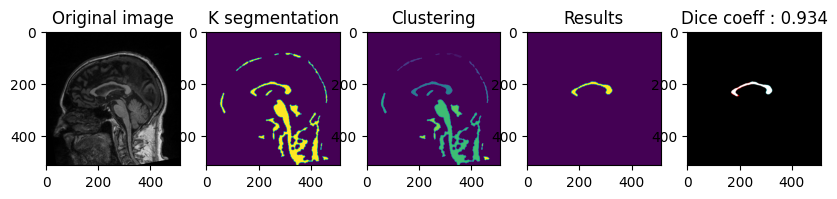

There are 4 brain MRI images
['g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs1-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs2-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs3-seg.png', 'g:\\Mon Drive\\2A\\IMA\\IMA204\\TP medical image segmentation/data/brainMRI\\MRIs4-seg.png']


c:\Users\eliot\AppData\Local\Programs\Python\Python39\lib\site-packages\imageio\plugins\pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


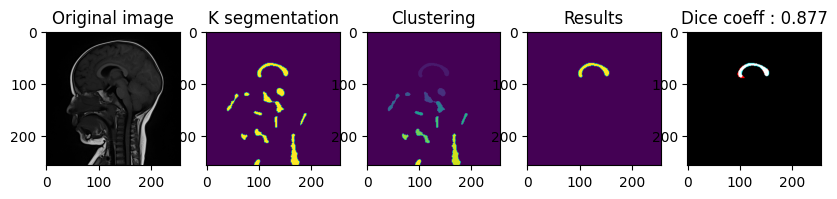

In [145]:
result1 = seg_corpus_callosum(3)
result2 = seg_corpus_callosum(1)